Time-series forecasting to forecast store sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer https://www.kaggle.com/competitions/store-sales-time-series-forecasting


File Descriptions and Data Field Information:

train.csv

    The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
    store_nbr identifies the store at which the products are sold.
    family identifies the type of product sold.
    sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
    onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

test.csv

    The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
    The dates in the test data are for the 15 days after the last date in the training data.

sample_submission.csv

    A sample submission file in the correct format.

stores.csv

    Store metadata, including city, state, type, and cluster.
    cluster is a grouping of similar stores.

oil.csv

    Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

holidays_events.csv

    Holidays and Events, with metadata
    NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
    Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

Additional Notes

    Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
    A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.


In [2]:
import gc
import os
import datetime
import pyarrow as pa
import re
import IPython
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import plotly.express as px
from darts import TimeSeries

from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import RFECV
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.model_selection import TimeSeriesFold, OneStepAheadFold
from skforecast.model_selection import backtesting_forecaster_multiseries
from skforecast.model_selection import bayesian_search_forecaster_multiseries
from skforecast.feature_selection import select_features_multiseries
from skforecast.preprocessing import RollingFeatures
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
# from feature_engine.datetime import DatetimeFeatures
# from feature_engine.creation import CyclicalFeatures
# from feature_engine.timeseries.forecasting import WindowFeatures

D:\Users\franek\miniconda3\envs\store-sales-ts-forecasting\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train = pd.read_csv("store-sales-ts-forecasting/input/train.csv", dtype={'id': 'int32', 'store_nbr': 'int32', 'sales': 'float32', 'onpromotion': 'int32'})
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int32  
 1   date         object 
 2   store_nbr    int32  
 3   family       object 
 4   sales        float32
 5   onpromotion  int32  
dtypes: float32(1), int32(3), object(2)
memory usage: 91.6+ MB


In [4]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [5]:
train.date = pd.to_datetime(train.date)

In [6]:
test = pd.read_csv("store-sales-ts-forecasting/input/test.csv", dtype={'id': 'int32', 'store_nbr': 'int32', 'onpromotion': 'int32'})
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int32 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int32 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int32 
dtypes: int32(3), object(2)
memory usage: 779.8+ KB


In [7]:
test.date = pd.to_datetime(test.date)

In [8]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [9]:
holidays_events = pd.read_csv("store-sales-ts-forecasting/input/holidays_events.csv")
holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [10]:
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [11]:
holidays_events.date = pd.to_datetime(holidays_events.date)

In [12]:
oil = pd.read_csv("store-sales-ts-forecasting/input/oil.csv", dtype={'dcoilwtico': 'float32'})
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float32
dtypes: float32(1), object(1)
memory usage: 14.4+ KB


In [13]:
oil.date = pd.to_datetime(oil.date)

In [14]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [15]:
stores = pd.read_csv("store-sales-ts-forecasting/input/stores.csv", dtype={'store_nbr': 'int32', 'cluster': 'int32'})
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int32 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int32 
dtypes: int32(2), object(3)
memory usage: 1.8+ KB


In [16]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [17]:
transactions = pd.read_csv("store-sales-ts-forecasting/input/transactions.csv", dtype={'store_nbr': 'int32', 'transactions': 'int32'})
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int32 
 2   transactions  83488 non-null  int32 
dtypes: int32(2), object(1)
memory usage: 1.3+ MB


In [18]:
transactions.date = pd.to_datetime(transactions.date)

In [19]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


### Check missing values

In [20]:
print((train.date.max() - train.date.min()).days + 1)  # 1688
train.nunique()  # 1684
# There are 4 missing dates in train data

1688


id             3000888
date              1684
store_nbr           54
family              33
sales           379610
onpromotion        362
dtype: int64

In [21]:
print((test.date.max() - test.date.min()).days + 1)  # 16
test.nunique()  # 16
# There are no missing dates in test data

16


id             28512
date              16
store_nbr         54
family            33
onpromotion      212
dtype: int64

In [22]:
dates_train = train.date.unique()
all_dates = pd.date_range(start=train.date.min(), end=train.date.max())
all_dates[~all_dates.isin(dates_train)]

# All 4 missing dates are on Christmas 25.12 - stores are probably closed that day

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)

We need to add missing dates for each of 54 stores (store_nbr column) and each of 33 products (family column) 

In [23]:
idxs_train = pd.MultiIndex.from_product(
    [all_dates, train.store_nbr.unique(), train.family.unique()],
    names=["date", "store_nbr", "family"],
)
train = (
    train.set_index(["date", "store_nbr", "family"]).reindex(idxs_train).reset_index()
)

In [24]:
train["id"] = train.index

In [25]:
train.fillna(0.0, inplace=True)

In [26]:
transactions.describe()  # no transactions equal to 0

,date,store_nbr,transactions
count,83488,83488.000000,83488.000000
mean,2015-05-20 16:07:40.866232064,26.939237,1694.602158
min,2013-01-01 00:00:00,1.000000,5.000000
25%,2014-03-27 00:00:00,13.000000,1046.000000
50%,2015-06-08 00:00:00,27.000000,1393.000000
75%,2016-07-14 06:00:00,40.000000,2079.000000
max,2017-08-15 00:00:00,54.000000,8359.000000
std,NaN,15.608204,963.286644


In [27]:
sales_store = train.groupby(["date", "store_nbr"]).sales.sum().reset_index()

In [28]:
transactions_sales = transactions.merge(
    sales_store, on=["date", "store_nbr"], how="right"
)

In [29]:
transactions_sales[
    (transactions_sales.sales != 0) & (transactions_sales.transactions.isna())
]
# there are 118 rows with NaN transactions and non zero sales

,date,store_nbr,transactions,sales
9135,2013-06-19,10,NaN,3802.291992
9160,2013-06-19,35,NaN,1699.047974
9168,2013-06-19,43,NaN,4642.495117
9179,2013-06-19,54,NaN,2977.852051
19795,2014-01-02,32,NaN,3146.146729
...,...,...,...,...
59342,2016-01-04,51,NaN,28280.580078
59344,2016-01-04,53,NaN,8702.972656
59345,2016-01-04,54,NaN,8711.512695
73716,2016-09-27,7,NaN,19783.335938


In [30]:
transactions_sales[
    (transactions_sales.sales == 0) & (transactions_sales.transactions.isna())
]
# there are 7546 rows with NaN transactions and zero sales

,date,store_nbr,transactions,sales
0,2013-01-01,1,NaN,0.0
1,2013-01-01,2,NaN,0.0
2,2013-01-01,3,NaN,0.0
3,2013-01-01,4,NaN,0.0
4,2013-01-01,5,NaN,0.0
...,...,...,...,...
84561,2017-04-15,52,NaN,0.0
84615,2017-04-16,52,NaN,0.0
84669,2017-04-17,52,NaN,0.0
84723,2017-04-18,52,NaN,0.0


In [31]:
transactions_sales.loc[
    (transactions_sales.sales == 0) & (transactions_sales.transactions.isna()),
    "transactions",
] = 0
interpolated_transactions = transactions_sales.groupby(
    "store_nbr", group_keys=False
).transactions.apply(lambda x: x.interpolate(limit_direction="both"))
transactions_sales["transactions"] = interpolated_transactions

In [32]:
missings_oil = pd.date_range(train.date.min(), test.date.max()).difference(oil.date)
# 486 missing dates with oil prices
missings_oil.weekday.value_counts()
# All missings are on weekends - saturdays and sundays

5    243
6    243
Name: count, dtype: int64

In [33]:
# Adding missing dates and filling values using linear interpolation
oil = oil.merge(pd.DataFrame(missings_oil, columns=["date"]), on="date", how="outer")
oil["dcoilwtico"] = oil.dcoilwtico.interpolate(limit_direction="both")

In [34]:
holidays_events.locale.value_counts()

locale
National    174
Local       152
Regional     24
Name: count, dtype: int64

In [35]:
holidays_events.locale.value_counts()

locale
National    174
Local       152
Regional     24
Name: count, dtype: int64

### Exploratory data analysis

In [36]:
train_pivot = train.pivot(index="date", columns=["store_nbr", "family"], values = "sales")

In [37]:
transactions_pivot = transactions_sales.pivot(index="date", columns="store_nbr", values = "transactions")

In [38]:
promotions_pivot = train.pivot(index="date", columns=["store_nbr", "family"], values = "onpromotion")

In [39]:
holidays_events[holidays_events.transferred == True] # more like normal days than holidays

,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
255,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True
268,2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True
303,2017-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,True
312,2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
324,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True


In [41]:
daily_sales = pd.DataFrame(train.groupby("date")["sales"].sum().reset_index())

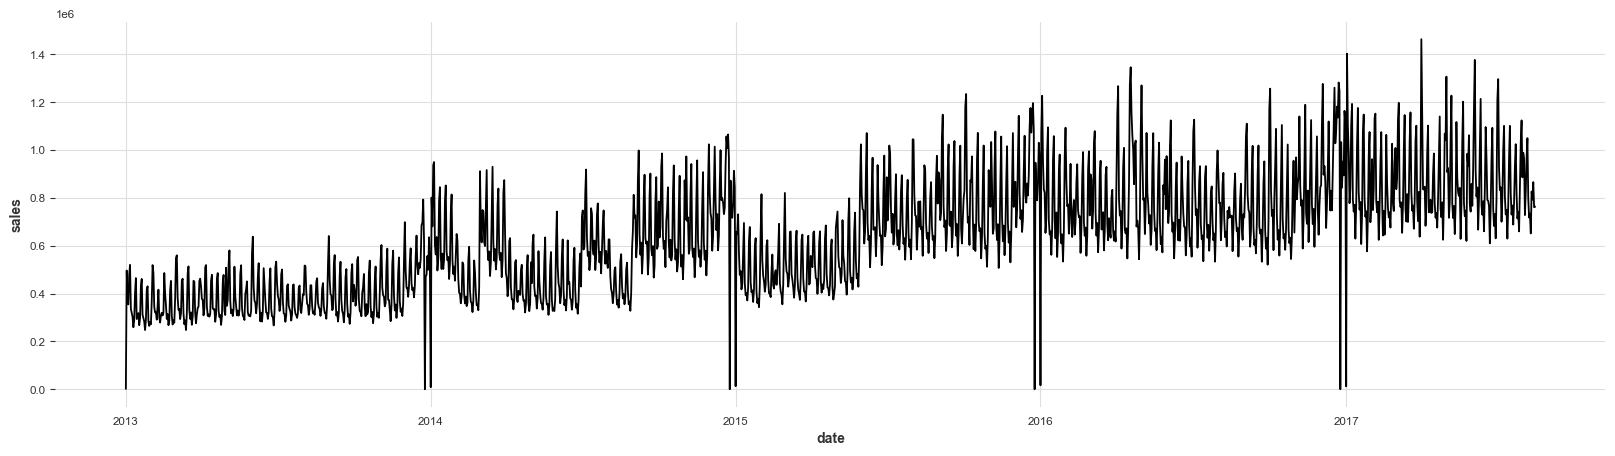

In [42]:
fig = plt.subplots(figsize=(20, 5))
sns.lineplot(data=daily_sales, x="date", y="sales")
sns.set_theme(palette=None)

In [43]:
daily_sales[daily_sales.sales == 0]

,date,sales
358,2013-12-25,0.0
723,2014-12-25,0.0
1088,2015-12-25,0.0
1454,2016-12-25,0.0


In [44]:
sales_stores = pd.DataFrame(train.groupby(["date", "store_nbr"])["sales"].sum().reset_index()).merge(stores, on="store_nbr")

In [45]:
sales_clusters = sales_stores.groupby(["date", "cluster"])["sales"].sum().reset_index()

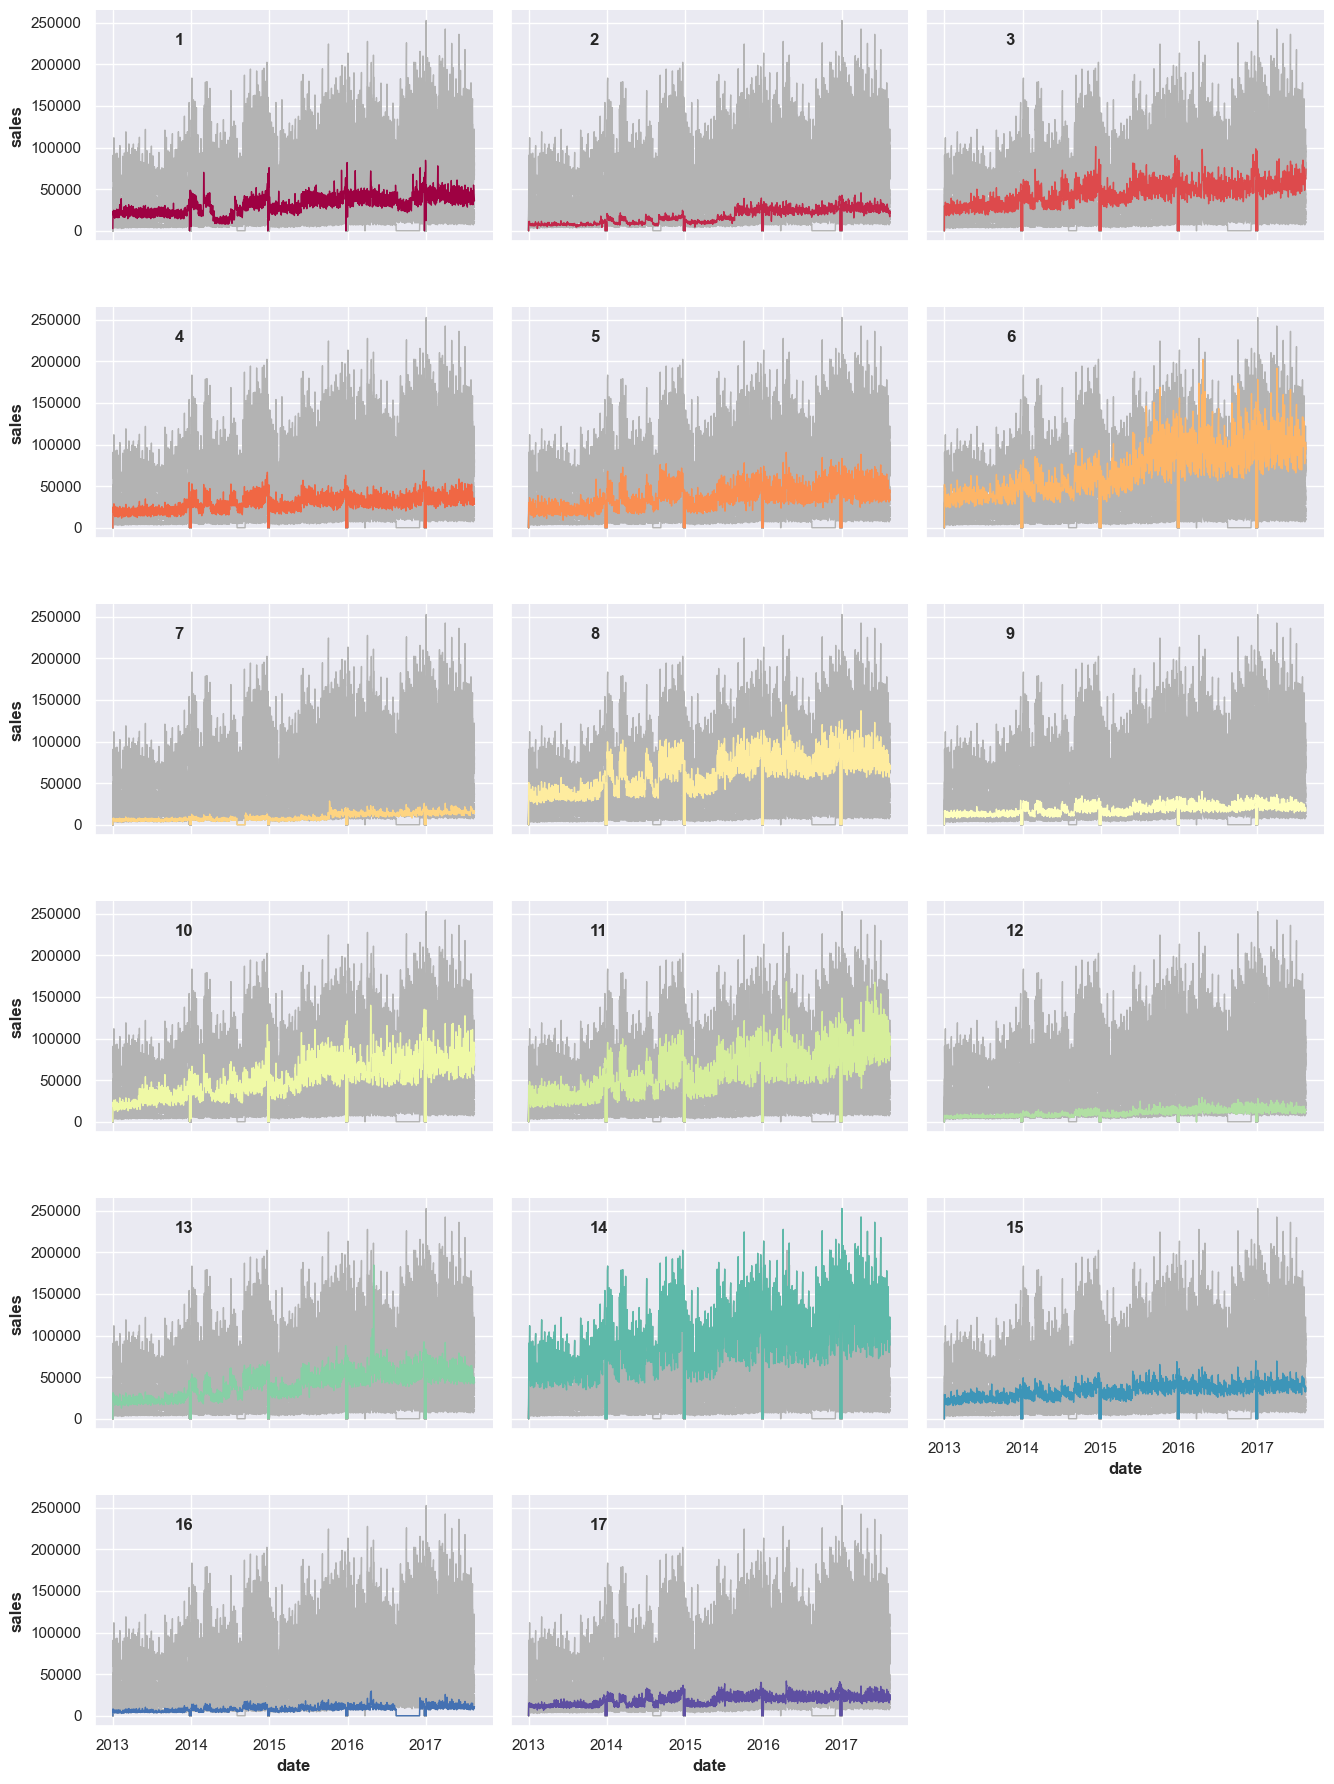

In [46]:

g = sns.relplot(data = sales_clusters, x = "date", y = "sales",
                col = "cluster", hue = "cluster",
                kind = "line", palette = "Spectral",   
                linewidth = 1, zorder = 5,
                col_wrap = 3, height = 3, aspect = 1.5, legend = False
               )

#add text and silhouettes
for time, ax in g.axes_dict.items():
    ax.text(.2, .85, time,
            transform = ax.transAxes, fontweight="bold"
           )
    sns.lineplot(data = sales_clusters, x = "date", y = "sales", units="cluster",
                 estimator = None, color= ".7", linewidth=1, ax=ax
                )

g.set_titles("")
g.set_axis_labels("date", "sales")
g.tight_layout()

In [47]:
sales_type = sales_stores.groupby(["date", "type"])["sales"].sum().reset_index()

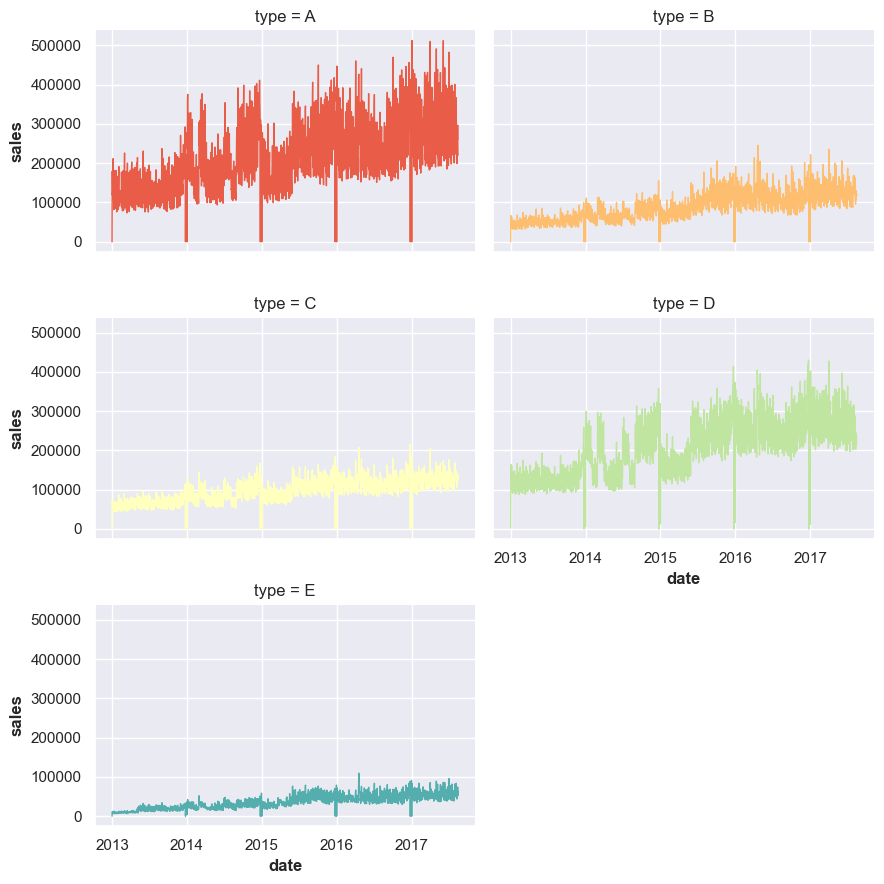

In [48]:
sns.relplot(data = sales_type, x = "date", y = "sales",
                col = "type", hue = "type",
                kind = "line", palette = "Spectral",   
                linewidth = 1, zorder = 5,
                col_wrap = 2, height = 3, aspect = 1.5, legend = False
               )


In [49]:
stores_cluster_type = stores.groupby(["type", "cluster"])["store_nbr"].count().rename("count").reset_index()

In [50]:
stores.groupby(["cluster", "type"]).size() # only stores from cluster 10 have different types (B, D, E)

cluster  type
1        D       3
2        D       2
3        C       7
4        D       3
5        A       1
6        B       6
7        C       2
8        D       3
9        D       2
10       B       1
         D       1
         E       4
11       A       3
12       C       1
13       D       4
14       A       4
15       C       5
16       B       1
17       A       1
dtype: int64

In [51]:
sales_stores.groupby("cluster")["sales"].median()

cluster
1     10061.180176
2      9934.375000
3      5488.530029
4      9386.262695
5     35384.750000
6     11311.504395
7      5330.695557
8     19453.234375
9      8051.258057
10     8308.760742
11    19425.331055
12    10105.174805
13    10466.116211
14    20335.979492
15     6345.166504
16     7618.205566
17    19155.391602
Name: sales, dtype: float64

In [52]:
sales_stores.groupby("type")["sales"].median()

type
A    21368.231445
B    10535.570312
C     6010.513672
D    10161.574219
E     9024.580078
Name: sales, dtype: float64

In [53]:
stores_cluster_type

,type,cluster,count
0,A,5,1
1,A,11,3
2,A,14,4
3,A,17,1
4,B,6,6
5,B,10,1
6,B,16,1
7,C,3,7
8,C,7,2
9,C,12,1


Text(0.5, 1.0, 'Store type-cluster count')

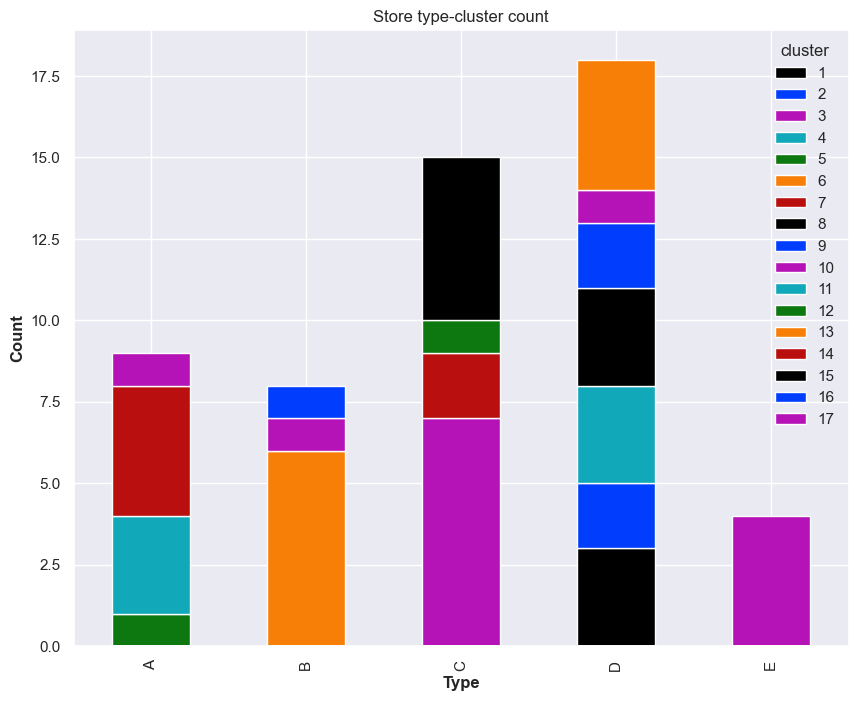

In [54]:

stores_cluster_type.pivot(index="type", columns="cluster", values="count").plot(kind='bar', stacked=True,figsize=(10, 8))
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Store type-cluster count')

In [55]:
stores.groupby(["state", "city"]).size()

state                           city         
Azuay                           Cuenca            3
Bolivar                         Guaranda          1
Chimborazo                      Riobamba          1
Cotopaxi                        Latacunga         2
El Oro                          Machala           2
Esmeraldas                      Esmeraldas        1
Guayas                          Daule             1
                                Guayaquil         8
                                Libertad          1
                                Playas            1
Imbabura                        Ibarra            1
Loja                            Loja              1
Los Rios                        Babahoyo          1
                                Quevedo           1
Manabi                          El Carmen         1
                                Manta             2
Pastaza                         Puyo              1
Pichincha                       Cayambe           1
                  

In [56]:
sales_stores.groupby(["state", "city"])["sales"].agg(["mean"])


mean
state                          city                       
Azuay                          Cuenca          9709.438477
Bolivar                        Guaranda        7730.752441
Chimborazo                     Riobamba        6746.397461
Cotopaxi                       Latacunga       6274.367188
El Oro                         Machala         9889.454102
Esmeraldas                     Esmeraldas      9710.717773
Guayas                         Daule          11367.311523
                               Guayaquil       9105.988281
                               Libertad        9077.269531
                               Playas          4547.795898
Imbabura                       Ibarra          6783.927734
Loja                           Loja           11172.985352
Los Rios                       Babahoyo       10513.549805
                               Quevedo         8399.585938
Manabi                         El Carmen       6550.641602
                               Manta           4120.953125
Pastaza                        Puyo            2423.105225
Pichincha                      Cayambe        16780.542969
                               Quito          18323.519531
Santa Elena                    Salinas         6765.994141
Santo Domingo de los Tsachilas Santo Domingo   7076.288086
Tungurahua                     Ambato         11938.506836

In [57]:
sales_stores

,date,store_nbr,sales,city,state,type,cluster
0,2013-01-01,1,0.000000,Quito,Pichincha,D,13
1,2013-01-01,2,0.000000,Quito,Pichincha,D,13
2,2013-01-01,3,0.000000,Quito,Pichincha,D,8
3,2013-01-01,4,0.000000,Quito,Pichincha,D,9
4,2013-01-01,5,0.000000,Santo Domingo,Santo Domingo de los Tsachilas,D,4
...,...,...,...,...,...,...,...
91147,2017-08-15,50,16879.121094,Ambato,Tungurahua,A,14
91148,2017-08-15,51,20154.558594,Guayaquil,Guayas,A,17
91149,2017-08-15,52,18600.044922,Manta,Manabi,A,11
91150,2017-08-15,53,8208.189453,Manta,Manabi,D,13


Let's see where and when there are 0 sales

In [58]:
sales_stores[sales_stores.sales == 0].groupby(["store_nbr"]).size() # most stores have 0 sales (are presumably closed) for only 9 days - on 01.01 and 25.12

store_nbr
1       10
2        9
3        9
4        9
5        9
6        9
7        9
8        9
9        9
10       9
11       9
12      69
13       9
14      47
15       9
16       9
17      11
18     119
19       9
20     777
21     938
22    1015
23       9
24     110
25      70
26       9
27       9
28       9
29     812
30      32
31       9
32       9
33       9
34       9
35       9
36     135
37       9
38       9
39       9
40       9
41       9
42     966
43      13
44       9
45       9
46       9
47       9
48       9
49       9
50       9
51       9
52    1570
53     519
54       9
dtype: int64

In [59]:
sales_store[(sales_store.sales == 0) & (sales_store.store_nbr == 2)]

,date,store_nbr,sales
1,2013-01-01,2,0.0
19333,2013-12-25,2,0.0
19711,2014-01-01,2,0.0
39043,2014-12-25,2,0.0
39421,2015-01-01,2,0.0
58753,2015-12-25,2,0.0
59131,2016-01-01,2,0.0
78517,2016-12-25,2,0.0
78895,2017-01-01,2,0.0


In [60]:
holidays_events.drop(holidays_events[(holidays_events.type == 'Work Day') | (holidays_events.transferred == True)].index, inplace = True)


In [61]:
holidays_events.groupby(["locale", "type"]).nunique()

date  locale_name  description  transferred
locale   type                                                   
Local    Additional    11            2            3            1
         Holiday      121           19           24            1
         Transfer       4            4            4            1
National Additional    40            1            7            1
         Bridge         5            1            3            1
         Event         55            1           43            1
         Holiday       52            1           10            1
         Transfer       8            1            4            1
Regional Holiday       24            4            4            1

In [62]:
print(holidays_events[holidays_events.locale == "Local"]["locale_name"].unique(), "\n", "\n",
holidays_events[holidays_events.locale == "Local"]["description"].unique())

['Manta' 'Cuenca' 'Libertad' 'Riobamba' 'Puyo' 'Guaranda' 'Latacunga'
 'Machala' 'Santo Domingo' 'El Carmen' 'Cayambe' 'Esmeraldas' 'Ambato'
 'Ibarra' 'Quevedo' 'Quito' 'Loja' 'Salinas' 'Guayaquil'] 
 
 ['Fundacion de Manta' 'Fundacion de Cuenca' 'Cantonizacion de Libertad'
 'Cantonizacion de Riobamba' 'Cantonizacion del Puyo'
 'Cantonizacion de Guaranda' 'Cantonizacion de Latacunga'
 'Fundacion de Machala' 'Fundacion de Santo Domingo'
 'Cantonizacion de El Carmen' 'Cantonizacion de Cayambe'
 'Fundacion de Esmeraldas' 'Fundacion de Riobamba' 'Fundacion de Ambato'
 'Fundacion de Ibarra' 'Cantonizacion de Quevedo'
 'Independencia de Guaranda' 'Independencia de Latacunga'
 'Independencia de Ambato' 'Fundacion de Quito-1' 'Fundacion de Quito'
 'Fundacion de Loja' 'Cantonizacion de Salinas' 'Fundacion de Guayaquil-1'
 'Fundacion de Guayaquil' 'Traslado Fundacion de Guayaquil'
 'Traslado Fundacion de Quito']


In [63]:
local_holidays = holidays_events[holidays_events.locale == "Local"]
local_holidays.loc[:,"description"] = local_holidays["description"].apply(lambda x: x.lower().replace("traslado ", "").split(" ")[0])
local_holidays = local_holidays.merge(pd.DataFrame(all_dates, columns=["date"]), how="right", on="date")
local_holidays = pd.get_dummies(local_holidays[["date", "description"]], columns=["description"], prefix="local", dtype="int")

In [64]:
local_holidays

,date,local_cantonizacion,local_fundacion,local_independencia
0,2013-01-01,0,0,0
1,2013-01-02,0,0,0
2,2013-01-03,0,0,0
3,2013-01-04,0,0,0
4,2013-01-05,0,0,0
...,...,...,...,...
1694,2017-08-11,0,0,0
1695,2017-08-12,0,0,0
1696,2017-08-13,0,0,0
1697,2017-08-14,0,0,0


In [65]:
print(holidays_events[holidays_events.locale == "National"]["locale_name"].unique(), "\n", "\n",
holidays_events[holidays_events.locale == "National"]["description"].unique())

['Ecuador'] 
 
 ['Primer Grito de Independencia' 'Traslado Independencia de Guayaquil'
 'Dia de Difuntos' 'Independencia de Cuenca' 'Navidad-4' 'Navidad-3'
 'Navidad-2' 'Puente Navidad' 'Navidad-1' 'Navidad' 'Navidad+1'
 'Puente Primer dia del ano' 'Primer dia del ano-1' 'Primer dia del ano'
 'Carnaval' 'Viernes Santo' 'Dia del Trabajo' 'Dia de la Madre-1'
 'Dia de la Madre' 'Batalla de Pichincha'
 'Inauguracion Mundial de futbol Brasil'
 'Mundial de futbol Brasil: Ecuador-Suiza'
 'Mundial de futbol Brasil: Ecuador-Honduras'
 'Mundial de futbol Brasil: Ecuador-Francia'
 'Mundial de futbol Brasil: Octavos de Final'
 'Mundial de futbol Brasil: Cuartos de Final'
 'Mundial de futbol Brasil: Semifinales'
 'Mundial de futbol Brasil: Tercer y cuarto lugar'
 'Mundial de futbol Brasil: Final' 'Black Friday' 'Cyber Monday'
 'Independencia de Guayaquil' 'Terremoto Manabi' 'Terremoto Manabi+1'
 'Terremoto Manabi+2' 'Terremoto Manabi+3' 'Terremoto Manabi+4'
 'Terremoto Manabi+5' 'Terremoto Manabi+6

In [66]:
national_holidays = holidays_events[holidays_events.locale == "National"]
national_holidays.loc[:,"description"] = national_holidays["description"].apply(lambda x: x.lower().split("+", 1)[0].split("-", 1)[0].split(":", 1)[0].replace("recupero ", "").replace("puente ", "").replace("inauguracion ", "").replace("traslado ", "").replace(" de cuenca", "").replace(" de guayaquil", "").replace(" ", "_"))
national_holidays = national_holidays.merge(pd.DataFrame(all_dates, columns=["date"]), how="right", on="date")
national_holidays = pd.get_dummies(national_holidays[["date", "description"]], columns=["description"], prefix="national", dtype="int")
national_holidays.drop_duplicates()


,date,national_batalla_de_pichincha,national_black_friday,national_carnaval,national_cyber_monday,national_dia_de_difuntos,national_dia_de_la_madre,national_dia_del_trabajo,national_independencia,national_mundial_de_futbol_brasil,national_navidad,national_primer_dia_del_ano,national_primer_grito_de_independencia,national_terremoto_manabi,national_viernes_santo
0,2013-01-01,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2013-01-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687,2017-08-11,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1688,2017-08-12,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1689,2017-08-13,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1690,2017-08-14,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [67]:
print(holidays_events[holidays_events.locale == "Regional"]["locale_name"].unique(), "\n", "\n",
holidays_events[holidays_events.locale == "Regional"]["description"].unique())

['Cotopaxi' 'Imbabura' 'Santo Domingo de los Tsachilas' 'Santa Elena'] 
 
 ['Provincializacion de Cotopaxi' 'Provincializacion de Imbabura'
 'Provincializacion de Santo Domingo' 'Provincializacion Santa Elena']


In [68]:
regional_holidays = holidays_events[holidays_events.locale == "Regional"]
regional_holidays.loc[:,"description"] = regional_holidays["description"].apply(lambda x: x.lower().split(" ")[0])
regional_holidays = regional_holidays.merge(pd.DataFrame(all_dates, columns=["date"]), how="right", on="date")
regional_holidays = pd.get_dummies(regional_holidays[["date", "description"]], columns=["description"], prefix="regional", dtype="int")
regional_holidays

,date,regional_provincializacion
0,2013-01-01,0
1,2013-01-02,0
2,2013-01-03,0
3,2013-01-04,0
4,2013-01-05,0
...,...,...
1683,2017-08-11,0
1684,2017-08-12,0
1685,2017-08-13,0
1686,2017-08-14,0


In [69]:
local_holidays[local_holidays["date"].duplicated()]

,date,local_cantonizacion,local_fundacion,local_independencia
176,2013-06-25,1,0,0
185,2013-07-03,0,1,0
543,2014-06-25,0,1,0
552,2014-07-03,0,1,0
910,2015-06-25,1,0,0
919,2015-07-03,0,1,0
1278,2016-06-25,1,0,0
1287,2016-07-03,0,1,0
1309,2016-07-24,0,1,0
1646,2017-06-25,0,1,0


In [70]:
local_holidays[local_holidays.date == "2013-06-25"]

,date,local_cantonizacion,local_fundacion,local_independencia
175,2013-06-25,0,1,0
176,2013-06-25,1,0,0


In [71]:
df_ = local_holidays.groupby("date").max().reset_index()
df_[df_.date == "2013-06-25"]

,date,local_cantonizacion,local_fundacion,local_independencia
175,2013-06-25,1,1,0


In [72]:
holidays_all_dates = local_holidays.merge(national_holidays, on="date").merge(regional_holidays, on="date").groupby("date").max().reset_index()

In [73]:
holidays_all_dates["no_holiday"] = abs(holidays_all_dates.iloc[:, 1:].max(axis = 1) - 1)

In [74]:
holidays_all_dates

,date,local_cantonizacion,local_fundacion,local_independencia,national_batalla_de_pichincha,national_black_friday,national_carnaval,national_cyber_monday,national_dia_de_difuntos,national_dia_de_la_madre,national_dia_del_trabajo,national_independencia,national_mundial_de_futbol_brasil,national_navidad,national_primer_dia_del_ano,national_primer_grito_de_independencia,national_terremoto_manabi,national_viernes_santo,regional_provincializacion,no_holiday
0,2013-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,2013-01-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2013-01-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2013-01-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2013-01-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1683,2017-08-11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1684,2017-08-12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1685,2017-08-13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1686,2017-08-14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [75]:
sales_holidays = train.groupby("date")["sales"].sum().reset_index().merge(holidays_all_dates, on="date")
train_holidays = train.merge(holidays_all_dates, on="date")

In [76]:
train_holidays

,date,store_nbr,family,id,sales,onpromotion,local_cantonizacion,local_fundacion,local_independencia,national_batalla_de_pichincha,...,national_dia_del_trabajo,national_independencia,national_mundial_de_futbol_brasil,national_navidad,national_primer_dia_del_ano,national_primer_grito_de_independencia,national_terremoto_manabi,national_viernes_santo,regional_provincializacion,no_holiday
0,2013-01-01,1,AUTOMOTIVE,0,0.000000,0.0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2013-01-01,1,BABY CARE,1,0.000000,0.0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2013-01-01,1,BEAUTY,2,0.000000,0.0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,2013-01-01,1,BEVERAGES,3,0.000000,0.0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,2013-01-01,1,BOOKS,4,0.000000,0.0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008011,2017-08-15,9,POULTRY,3008011,438.132996,0.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3008012,2017-08-15,9,PREPARED FOODS,3008012,154.552994,1.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3008013,2017-08-15,9,PRODUCE,3008013,2419.729004,148.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3008014,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,3008014,121.000000,8.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Sales distribution by national_independencia')

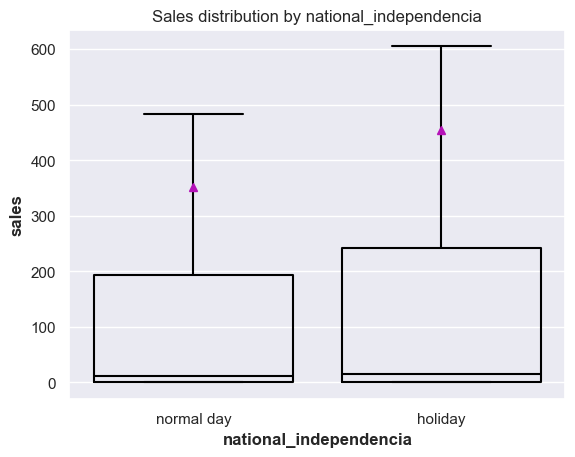

In [145]:
ax = sns.boxplot(x='national_independencia', y='sales', data=train_holidays[(train_holidays.national_independencia == 1) | (train_holidays.no_holiday == 1)],  fill=False, showfliers=False, showmeans=True)
plt.xticks([0, 1], ["normal day", "holiday"])

plt.title('Sales distribution by national_independencia')

Text(0.5, 1.0, 'Sales distribution by national_navidad')

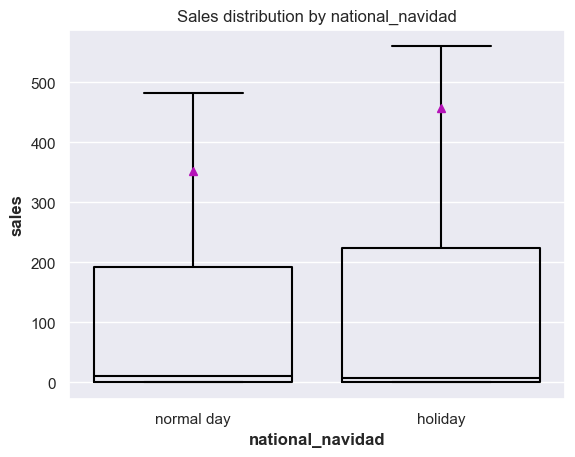

In [146]:

ax = sns.boxplot(x='national_navidad', y='sales', data=train_holidays[(train_holidays.national_navidad == 1) | (train_holidays.no_holiday == 1)],  fill=False, showfliers=False, showmeans=True)
plt.xticks([0, 1], ["normal day", "holiday"])

plt.title('Sales distribution by national_navidad')

Text(0.5, 1.0, 'Sales distribution by national_primer_dia_del_ano')

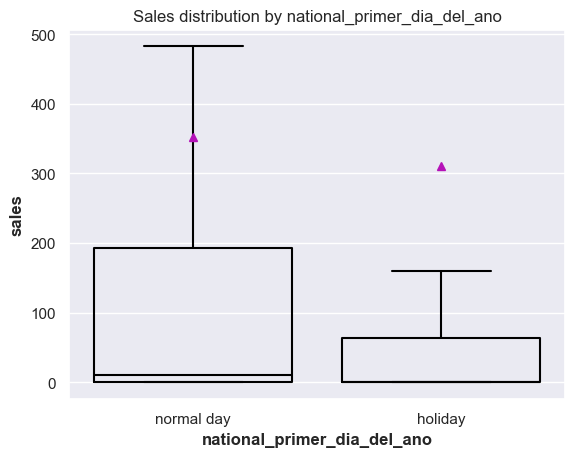

In [147]:

ax = sns.boxplot(x='national_primer_dia_del_ano', y='sales', data=train_holidays[(train_holidays.national_primer_dia_del_ano == 1) | (train_holidays.no_holiday == 1)],  fill=False, showfliers=False, showmeans=True)
plt.xticks([0, 1], ["normal day", "holiday"])

plt.title('Sales distribution by national_primer_dia_del_ano')

Text(0.5, 1.0, 'Sales distribution by national_primer_grito_de_independencia')

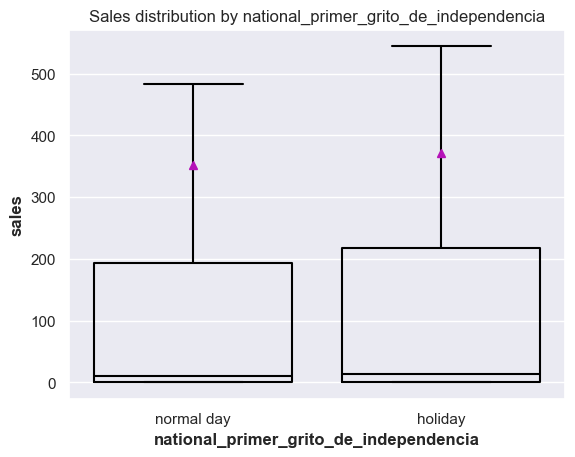

In [148]:
ax = sns.boxplot(x='national_primer_grito_de_independencia', y='sales', data=train_holidays[(train_holidays.national_primer_grito_de_independencia == 1) | (train_holidays.no_holiday == 1)],  fill=False, showfliers=False, showmeans=True)
plt.xticks([0, 1], ["normal day", "holiday"])

plt.title('Sales distribution by national_primer_grito_de_independencia')

Text(0.5, 1.0, 'Sales distribution by national_batalla_de_pichincha')

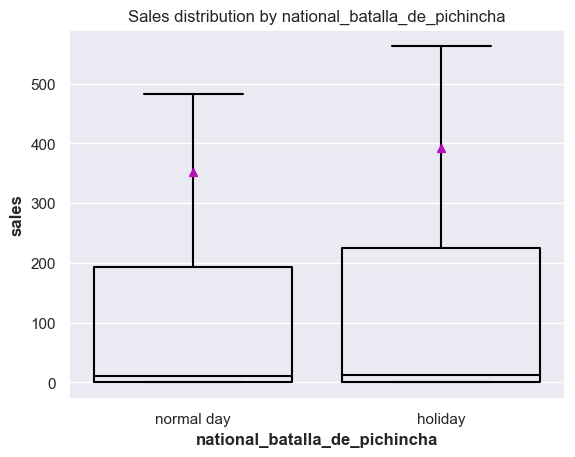

In [149]:
ax = sns.boxplot(x='national_batalla_de_pichincha', y='sales', data=train_holidays[(train_holidays.national_batalla_de_pichincha == 1) | (train_holidays.no_holiday == 1)],  fill=False, showfliers=False, showmeans=True)
plt.xticks([0, 1], ["normal day", "holiday"])

plt.title('Sales distribution by national_batalla_de_pichincha')

Text(0.5, 1.0, 'Sales distribution by national_black_friday')

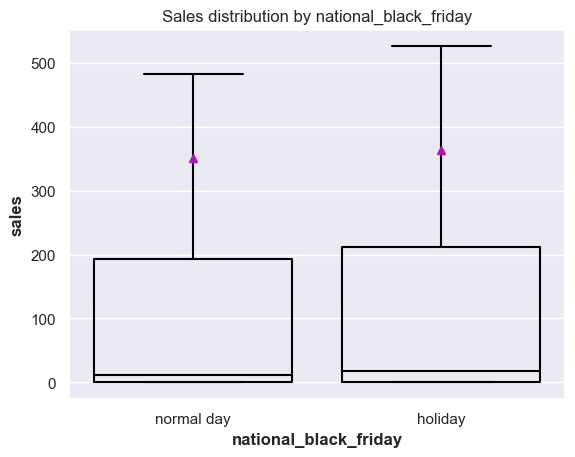

In [150]:
ax = sns.boxplot(x='national_black_friday', y='sales', data=train_holidays[(train_holidays.national_black_friday == 1) | (train_holidays.no_holiday == 1)],  fill=False, showfliers=False, showmeans=True)
plt.xticks([0, 1], ["normal day", "holiday"])

plt.title('Sales distribution by national_black_friday')

Text(0.5, 1.0, 'Sales distribution by national_carnaval')

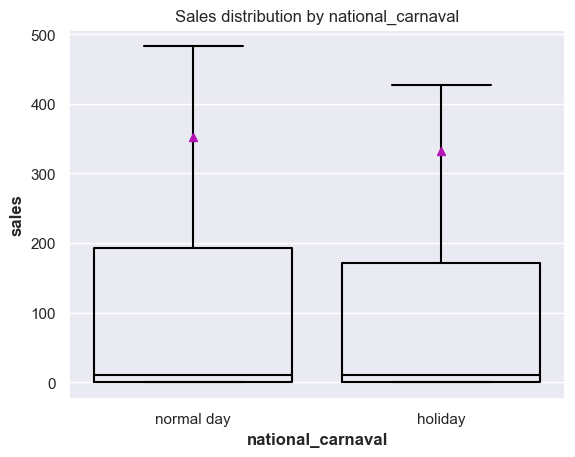

In [151]:
ax = sns.boxplot(x='national_carnaval', y='sales', data=train_holidays[(train_holidays.national_carnaval == 1) | (train_holidays.no_holiday == 1)],  fill=False, showfliers=False, showmeans=True)
plt.xticks([0, 1], ["normal day", "holiday"])

plt.title('Sales distribution by national_carnaval')

Text(0.5, 1.0, 'Sales distribution by national_cyber_monday')

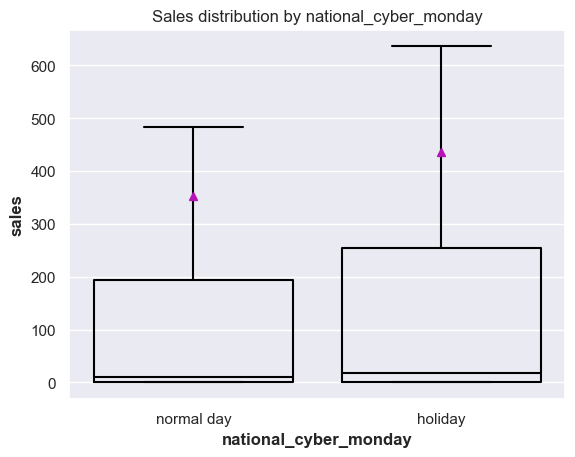

In [152]:
ax = sns.boxplot(x='national_cyber_monday', y='sales', data=train_holidays[(train_holidays.national_cyber_monday == 1) | (train_holidays.no_holiday == 1)],  fill=False, showfliers=False, showmeans=True)
plt.xticks([0, 1], ["normal day", "holiday"])

plt.title('Sales distribution by national_cyber_monday')

Text(0.5, 1.0, 'Sales distribution by national_dia_de_difuntos')

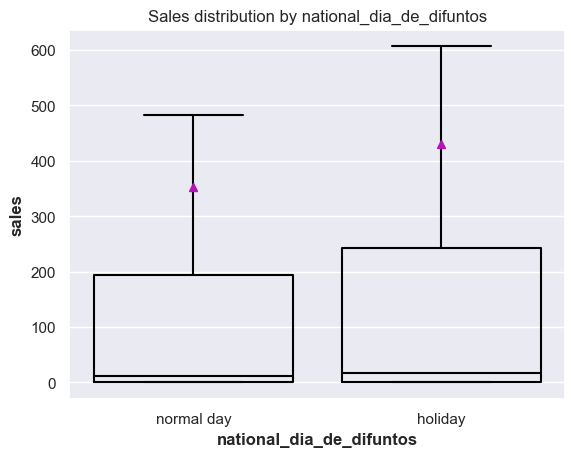

In [153]:
ax = sns.boxplot(x='national_dia_de_difuntos', y='sales', data=train_holidays[(train_holidays.national_dia_de_difuntos == 1) | (train_holidays.no_holiday == 1)],  fill=False, showfliers=False, showmeans=True)
plt.xticks([0, 1], ["normal day", "holiday"])

plt.title('Sales distribution by national_dia_de_difuntos')

Text(0.5, 1.0, 'Sales distribution by national_dia_de_la_madre')

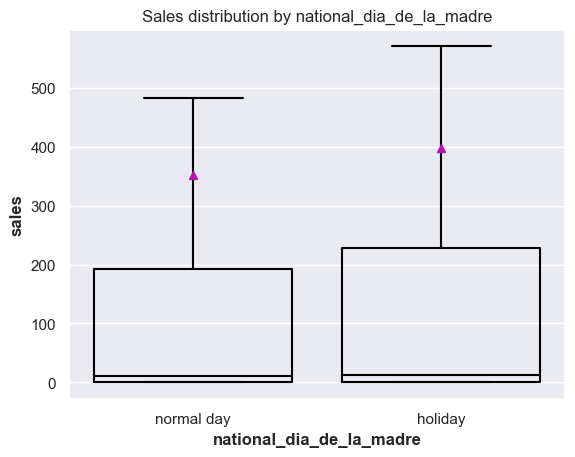

In [154]:
ax = sns.boxplot(x='national_dia_de_la_madre', y='sales', data=train_holidays[(train_holidays.national_dia_de_la_madre == 1) | (train_holidays.no_holiday == 1)],  fill=False, showfliers=False, showmeans=True)
plt.xticks([0, 1], ["normal day", "holiday"])

plt.title('Sales distribution by national_dia_de_la_madre')

Text(0.5, 1.0, 'Sales distribution by national_dia_del_trabajo')

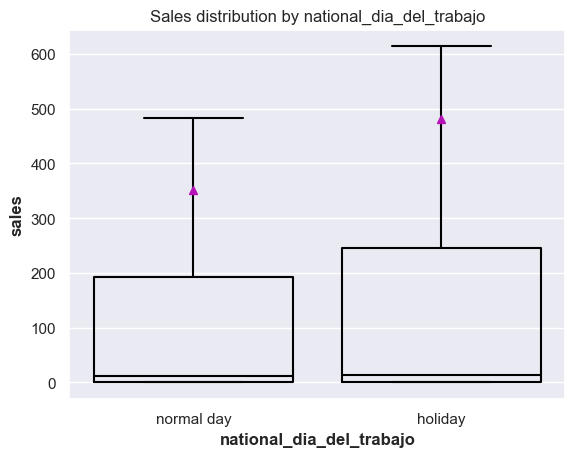

In [155]:
ax = sns.boxplot(x='national_dia_del_trabajo', y='sales', data=train_holidays[(train_holidays.national_dia_del_trabajo == 1) | (train_holidays.no_holiday == 1)],  fill=False, showfliers=False, showmeans=True)
plt.xticks([0, 1], ["normal day", "holiday"])

plt.title('Sales distribution by national_dia_del_trabajo')

Text(0.5, 1.0, 'Sales distribution by national_mundial_de_futbol_brasil')

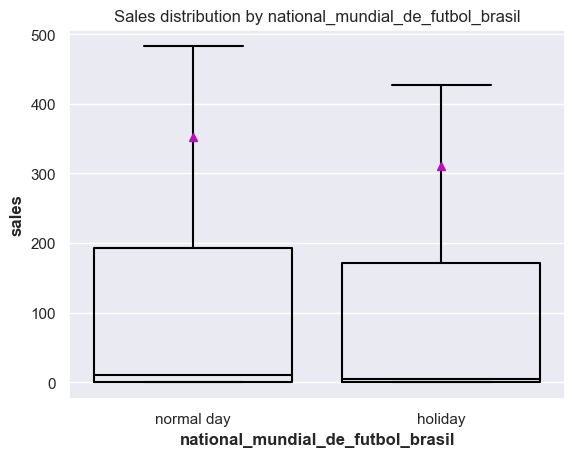

In [156]:
ax = sns.boxplot(x='national_mundial_de_futbol_brasil', y='sales', data=train_holidays[(train_holidays.national_mundial_de_futbol_brasil == 1) | (train_holidays.no_holiday == 1)],  fill=False, showfliers=False, showmeans=True)
plt.xticks([0, 1], ["normal day", "holiday"])

plt.title('Sales distribution by national_mundial_de_futbol_brasil')

Text(0.5, 1.0, 'Sales distribution by national_terremoto_manabi')

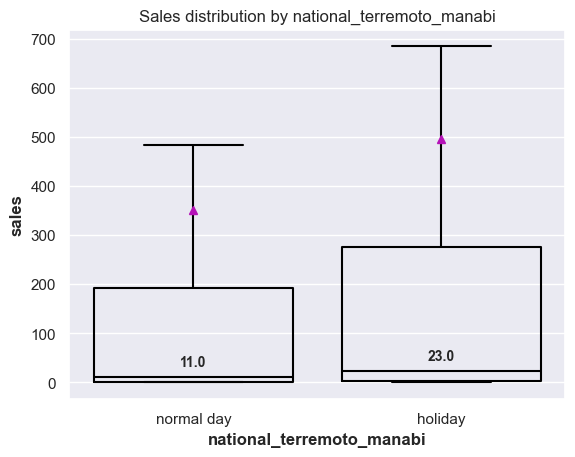

In [157]:
ax = sns.boxplot(x='national_terremoto_manabi', y='sales', data=train_holidays[(train_holidays.national_terremoto_manabi == 1) | (train_holidays.no_holiday == 1)],  fill=False, showfliers=False, showmeans=True)
plt.xticks([0, 1], ["normal day", "holiday"])
medians = train_holidays[(train_holidays.national_terremoto_manabi == 1) | (train_holidays.no_holiday == 1)].groupby(['national_terremoto_manabi'])['sales'].median()
vertical_offset = train_holidays[(train_holidays.national_terremoto_manabi == 1) | (train_holidays.no_holiday == 1)]['sales'].median() * 2# offset from median for display
for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='small',weight='semibold')
plt.title('Sales distribution by national_terremoto_manabi')

Text(0.5, 1.0, 'Sales distribution by national_viernes_santo')

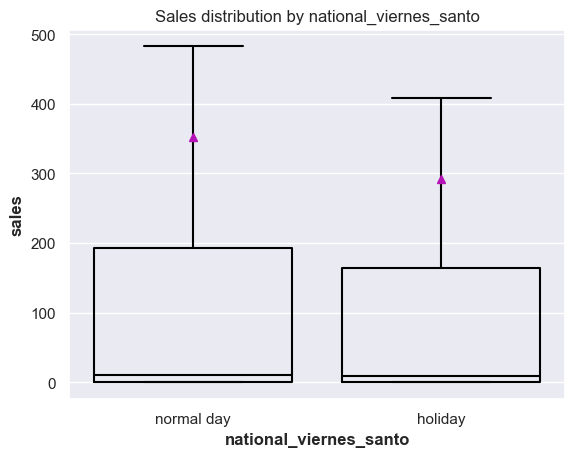

In [158]:
ax = sns.boxplot(x='national_viernes_santo', y='sales', data=train_holidays[(train_holidays.national_viernes_santo == 1) | (train_holidays.no_holiday == 1)],  fill=False, showfliers=False, showmeans=True)
plt.xticks([0, 1], ["normal day", "holiday"])
# plt.yscale("log")
plt.title('Sales distribution by national_viernes_santo')

In [130]:
families_stores = train.groupby(["store_nbr", "family"])["sales"].sum()
families_stores_count = families_stores[families_stores> 0].groupby(["store_nbr"]).count().reset_index()

In [131]:
families_stores_count # all stores sell at least 30 different products (families)

,store_nbr,sales
0,1,32
1,2,33
2,3,33
3,4,33
4,5,33
5,6,33
6,7,33
7,8,33
8,9,32
9,10,32


In [132]:
train[["year", "week", "dayofweek"]] = train.date.dt.isocalendar()
train["month"] = train.date.dt.month

Text(0.5, 1.0, 'Sales distribution by day of the week')

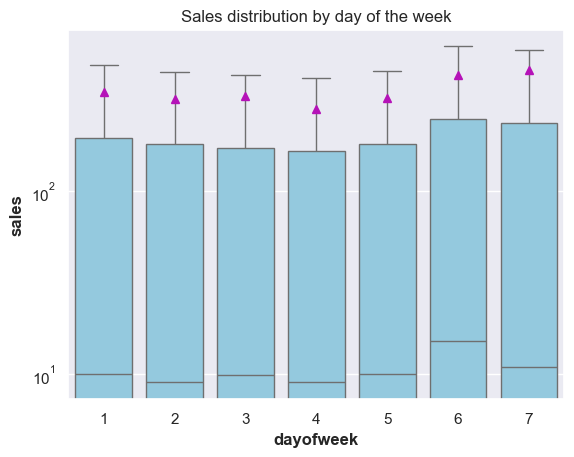

In [142]:
ax = sns.boxplot(x='dayofweek', y='sales', data=train, showfliers=False, showmeans=True, color='skyblue')
ax.set_yscale('log')
plt.title('Sales distribution by day of the week')

Text(0.5, 1.0, 'Sales distribution by day of the month')

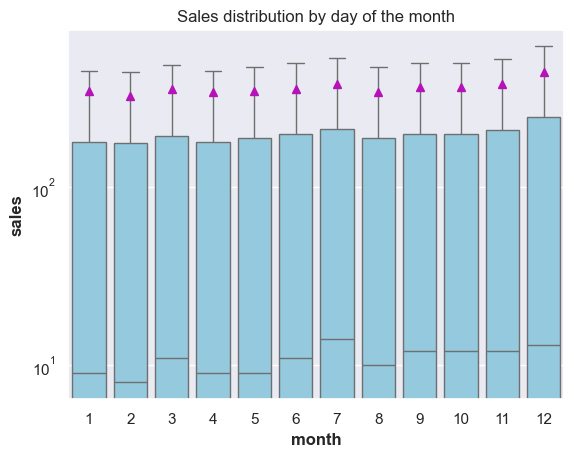

In [143]:
ax = sns.boxplot(x='month', y='sales', data=train, showfliers=False, showmeans=True, color='skyblue')
ax.set_yscale('log')
plt.title('Sales distribution by day of the month')

Text(0.5, 1.0, 'Sales distribution by day of the year')

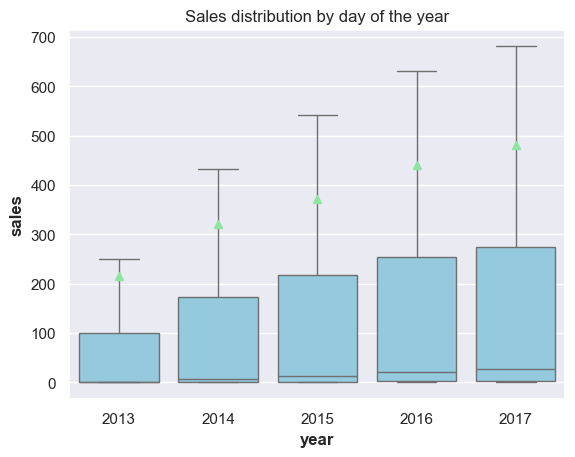

In [280]:
ax = sns.boxplot(x='year', y='sales', data=train, showfliers=False, showmeans=True, color='skyblue')
plt.title('Sales distribution by day of the year')

In [223]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

train["last_day"] = train["date"].apply(lambda x: (x.date() + relativedelta(day=31) == x.date()))
train["15th_day"] = train["date"].apply(lambda x: (x.date() + relativedelta(day=15) == x.date()))


Text(0.5, 1.0, 'Sales distribution by day of the last_day')

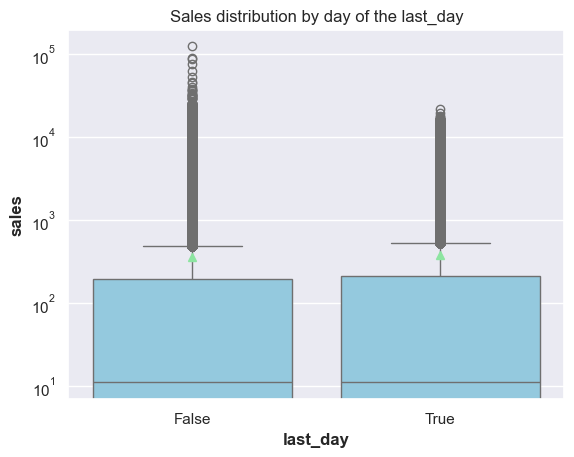

In [239]:
# fig, ax = plt.subplots(figsize=(40, 5))
ax = sns.boxplot(x='last_day', y='sales', data=train, showmeans=True, color='skyblue')
ax.set_yscale('log')
plt.title('Sales distribution by day of the last_day')


Text(0.5, 1.0, 'Sales distribution by day of the 15th_day')

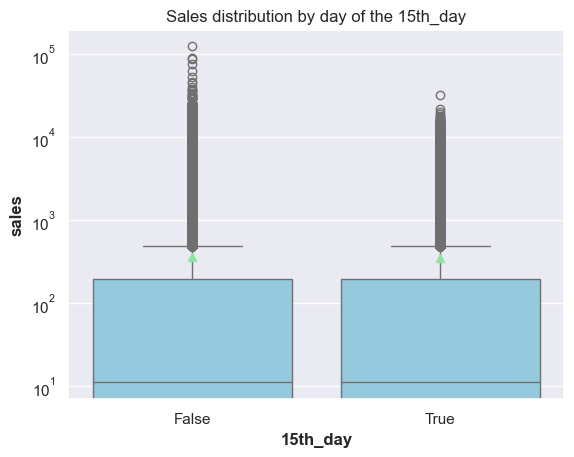

In [240]:
ax = sns.boxplot(x='15th_day', y='sales', data=train, showmeans=True, color='skyblue')
ax.set_yscale('log')
plt.title('Sales distribution by day of the 15th_day')


In [ ]:
average_sales = pd.DataFrame(train.groupby("date")[["sales", "onpromotion"]].mean().reset_index())

In [207]:
average_sales = average_sales.merge(oil, on = "date", how = "left")


<Axes: xlabel='dcoilwtico', ylabel='sales'>

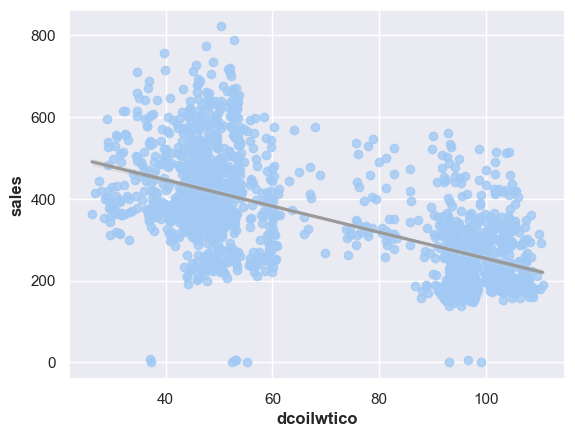

In [208]:
sns.set_palette("pastel")
sns.regplot(data=average_sales, x="dcoilwtico", y="sales",  line_kws=dict(color=".6"))

<Axes: xlabel='onpromotion', ylabel='sales'>

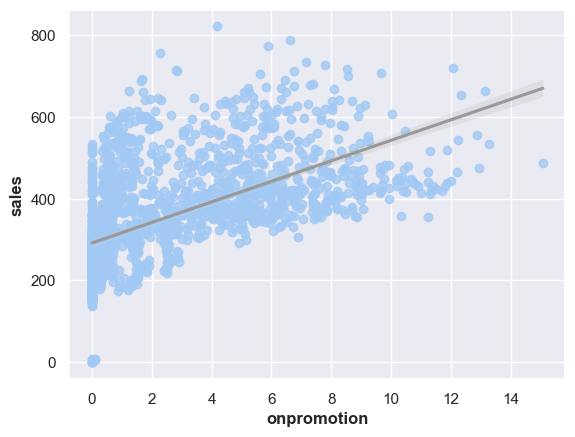

In [209]:
sns.set_palette("pastel")
sns.regplot(data=average_sales, x="onpromotion", y="sales",  line_kws=dict(color=".6"))

In [241]:
train.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [254]:
sales_family = train.groupby(["family", "date"])["sales"].sum().reset_index()
sales_family[sales_family.family.isin(['GROCERY I', 'GROCERY II'])]

,family,date,sales
20256,GROCERY I,2013-01-01,700.0
20257,GROCERY I,2013-01-02,202020.0
20258,GROCERY I,2013-01-03,144878.0
20259,GROCERY I,2013-01-04,135754.0
20260,GROCERY I,2013-01-05,188356.0
...,...,...,...
23627,GROCERY II,2017-08-11,1653.0
23628,GROCERY II,2017-08-12,1555.0
23629,GROCERY II,2017-08-13,1504.0
23630,GROCERY II,2017-08-14,1371.0


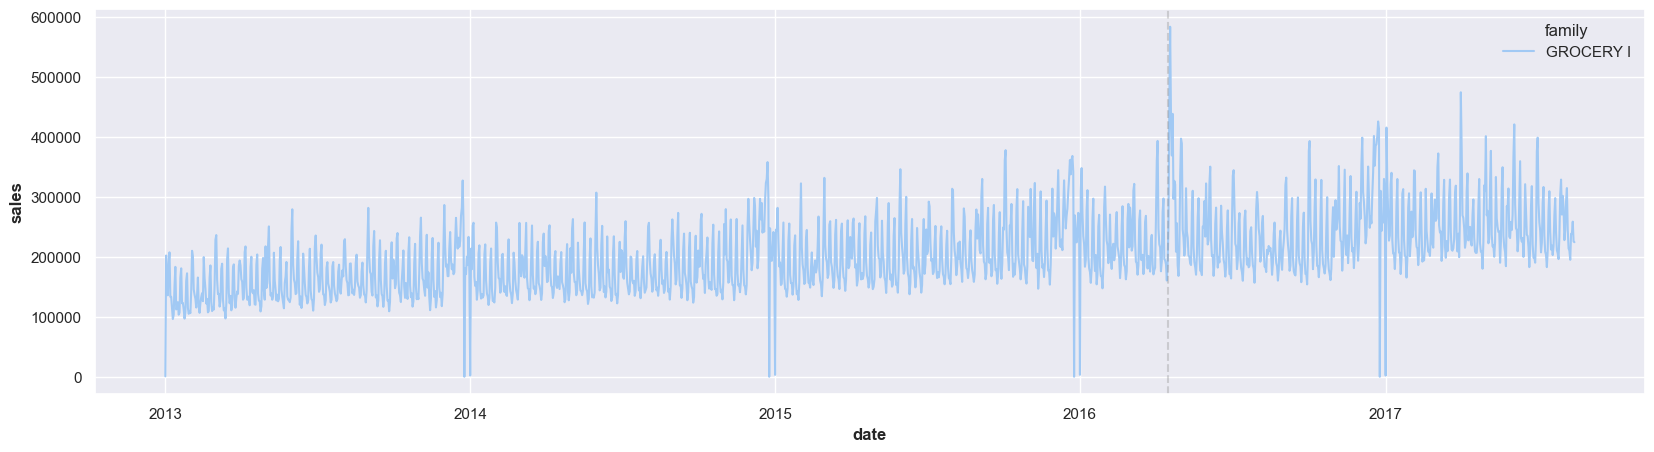

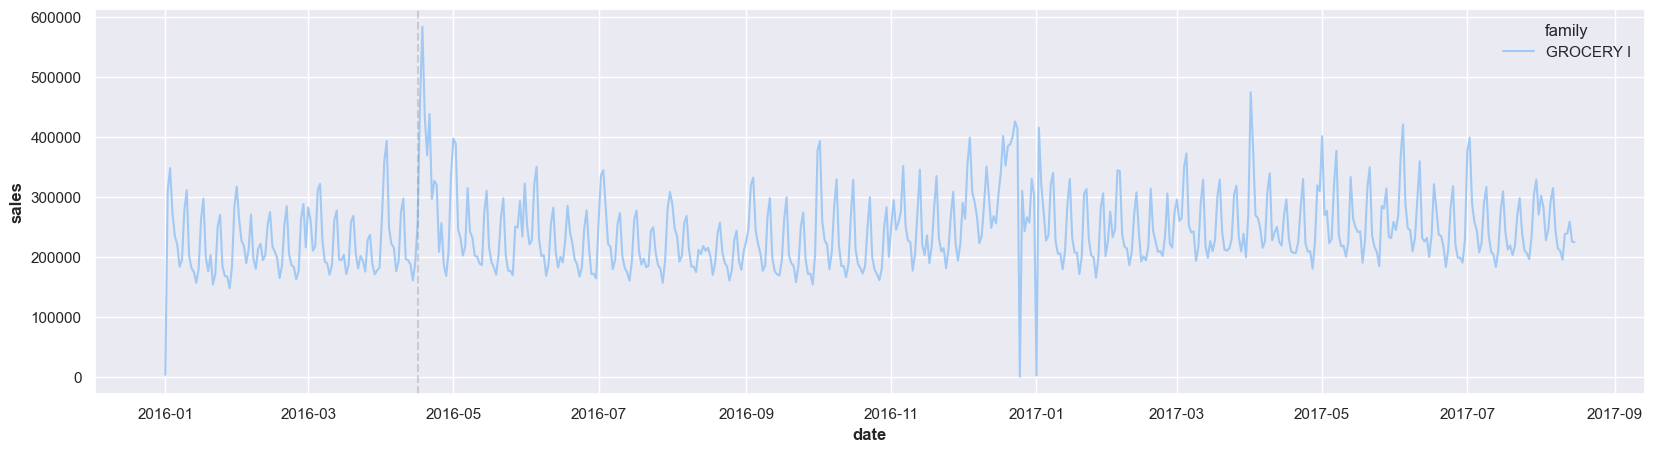

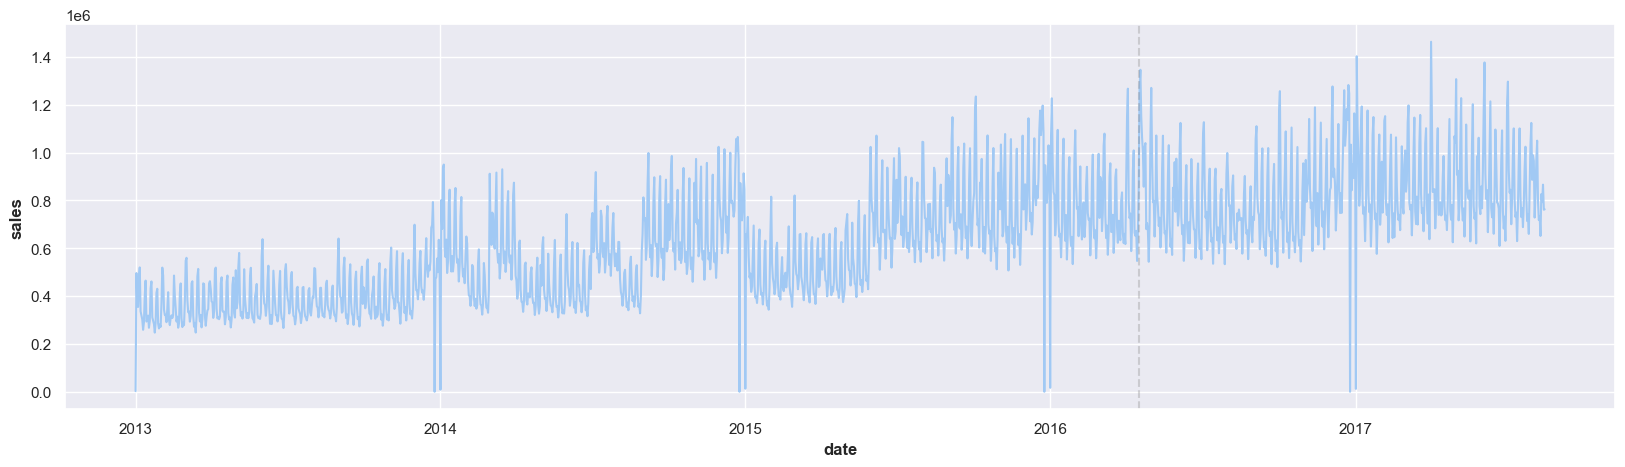

In [287]:
fig = plt.subplots(figsize=(20, 5))
sns.lineplot(data=sales_family[sales_family.family.isin(['GROCERY I'])], x="date", y="sales", hue = "family")
plt.axvline(x=pd.to_datetime("2016-04-16"), color='grey', linestyle='--', alpha=.3)

fig = plt.subplots(figsize=(20, 5))
sns.lineplot(data=sales_family[(sales_family.family.isin(['GROCERY I']) & (sales_family.date >= pd.to_datetime("2016-01-01")))], x="date", y="sales", hue = "family")
plt.axvline(x=pd.to_datetime("2016-04-16"), color='grey', linestyle='--', alpha=.3)

fig = plt.subplots(figsize=(20, 5))
sns.lineplot(data=daily_sales, x="date", y="sales")
plt.axvline(x=pd.to_datetime("2016-04-16"), color='grey', linestyle='--', alpha=.3)
